In [118]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

#import all dependencies
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import os
import re
from keras.utils import to_categorical 
from sklearn.model_selection import train_test_split
from nltk.tokenize import TweetTokenizer
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.util import ngrams
from collections import Counter

import keras 
from keras.models import Sequential
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV


from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D



from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import confusion_matrix

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_test.csv
/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_train.csv


In [119]:
#list of items in the directory
os.listdir("../input/covid-19-nlp-text-classification")

['Corona_NLP_test.csv', 'Corona_NLP_train.csv']

Reading the dataset

In [120]:
train = pd.read_csv("../input/covid-19-nlp-text-classification/Corona_NLP_train.csv", encoding="Latin_1" )
test = pd.read_csv('../input/covid-19-nlp-text-classification/Corona_NLP_test.csv',encoding='latin_1')

Checking the datasets for missing and null data

In [121]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


In [122]:
#display the dataset
train.head(30)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative
5,3804,48756,"ÃT: 36.319708,-82.363649",16-03-2020,As news of the regionÂs first confirmed COVID...,Positive
6,3805,48757,"35.926541,-78.753267",16-03-2020,Cashier at grocery store was sharing his insig...,Positive
7,3806,48758,Austria,16-03-2020,Was at the supermarket today. Didn't buy toile...,Neutral
8,3807,48759,"Atlanta, GA USA",16-03-2020,Due to COVID-19 our retail store and classroom...,Positive
9,3808,48760,"BHAVNAGAR,GUJRAT",16-03-2020,"For corona prevention,we should stop to buy th...",Negative


In [123]:

# Function to calculate missing values by column
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
         # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [124]:
missing_values_table(test).head(20)

Your selected dataframe has 6 columns.
There are 1 columns that have missing values.


,Missing Values,% of Total Values
Location,834,22.0


From the analysis so far, only the location column has missing dataset.
the UserName and ScreenName has no usefulness as they have been coded, so we can drop them as they are not useful to our analysis. 

In [125]:
train.drop(labels= ['UserName', 'ScreenName'],axis=1, inplace=True)
test.drop(labels= ['UserName', 'ScreenName'],axis=1, inplace=True)

In [126]:
train

,Location,TweetAt,OriginalTweet,Sentiment
0,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative
...,...,...,...,...
41152,"Wellington City, New Zealand",14-04-2020,Airline pilots offering to stock supermarket s...,Neutral
41153,NaN,14-04-2020,Response to complaint not provided citing COVI...,Extremely Negative
41154,NaN,14-04-2020,You know itÂs getting tough when @KameronWild...,Positive
41155,NaN,14-04-2020,Is it wrong that the smell of hand sanitizer i...,Neutral


In [127]:
test

,Location,TweetAt,OriginalTweet,Sentiment
0,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral
...,...,...,...,...
3793,Israel ??,16-03-2020,Meanwhile In A Supermarket in Israel -- People...,Positive
3794,"Farmington, NM",16-03-2020,Did you panic buy a lot of non-perishable item...,Negative
3795,"Haverford, PA",16-03-2020,Asst Prof of Economics @cconces was on @NBCPhi...,Neutral
3796,NaN,16-03-2020,Gov need to do somethings instead of biar je r...,Extremely Negative


We can also check for null values and duplicates using heatmaps

<AxesSubplot:>

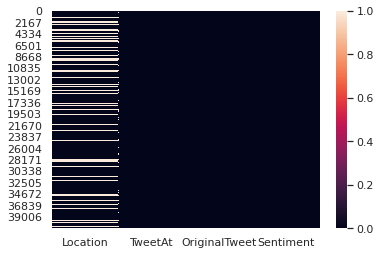

In [128]:
sns.heatmap(train.isnull())

<AxesSubplot:>

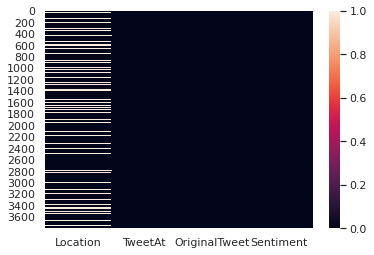

In [129]:
sns.heatmap(test.isnull())

we can drop duplicates and null values to reduce the variation in our dataset

In [130]:
train.drop_duplicates(inplace=True)
test.drop_duplicates(inplace=True)

In [131]:
print('Train data shape: ',train.shape)
print('Test data shape: ',test.shape)

Train data shape:  (41157, 4)
Test data shape:  (3798, 4)


Check if the dependent variables are distributed

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Sentiment', ylabel='count'>

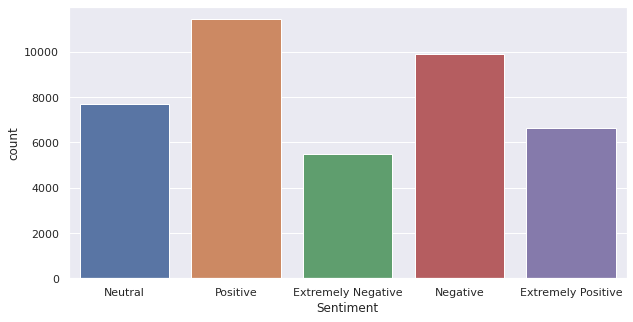

In [132]:
sns.set_style("darkgrid")
sns.set(rc={'figure.figsize' :(10, 5)})
sns.countplot(train['Sentiment'])

From our sentiment, we noticed we have extremely negative and extremely positive which are not much different from negative and positive respectively

In [133]:
train['Sentiment'] = train.Sentiment.str.replace('Extremely Positive', 'Positive')
train['Sentiment'] = train.Sentiment.str.replace('Extremely Negative', 'Negative')

test['Sentiment'] = test.Sentiment.str.replace('Extremely Positive', 'Positive')
test['Sentiment'] = test.Sentiment.str.replace('Extremely Negative', 'Negative')

In [134]:
train.Sentiment.value_counts()

Positive    18046
Negative    15398
Neutral      7713
Name: Sentiment, dtype: int64

We can make a new countplot to observe the variables

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Sentiment', ylabel='count'>

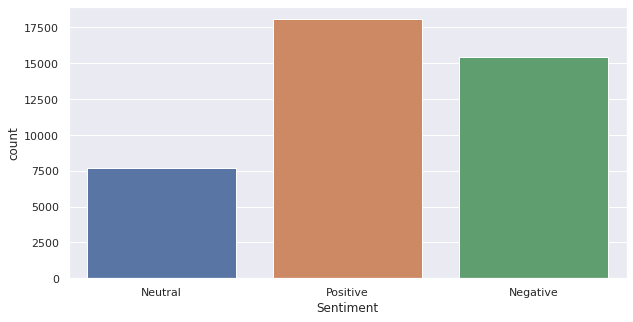

In [135]:
sns.countplot(train['Sentiment'])

The positive and negative are much larger than the neutral, the datasets looks like there is an undersampling or oversampling.

Checking other variables of our datasets, e.g Location.

In [136]:
train['Location'].describe()

count      32567
unique     12220
top       London
freq         540
Name: Location, dtype: object

The location variable has 32567 values while 22% of the dataset are missing

In [137]:
train['Location'].value_counts(dropna = False)[:40]

NaN                        8590
London                      540
United States               528
London, England             520
New York, NY                395
Washington, DC              373
United Kingdom              337
Los Angeles, CA             281
India                       268
UK                          232
Australia                   225
USA                         223
England, United Kingdom     191
Canada                      191
Toronto, Ontario            160
Global                      159
Chicago, IL                 155
California, USA             153
San Francisco, CA           152
Boston, MA                  150
New York, USA               140
New Delhi, India            138
Atlanta, GA                 126
New York                    126
Mumbai, India               109
Worldwide                   101
Lagos, Nigeria               99
Texas, USA                   98
Austin, TX                   98
Houston, TX                  98
London, UK                   96
Toronto 

There are some unnecessary repetitions in the datasets of places like Florida, US etc whereas we can have a unique value.

In [138]:
train['Location'] = train['Location'].str.split(",").str[0]

In [139]:
train['Location'].value_counts()[:40]

London            1247
New York           709
United States      530
Washington         504
Los Angeles        402
Toronto            346
United Kingdom     342
India              276
Chicago            262
England            255
UK                 246
USA                231
Australia          230
California         211
San Francisco      206
Sydney             202
New Delhi          201
Melbourne          199
Canada             198
Mumbai             197
Boston             197
Atlanta            165
Global             159
Houston            156
Texas              145
Lagos              136
Austin             130
Florida            121
Seattle            120
Nairobi            117
Dallas             115
Philadelphia       114
Manchester         111
Vancouver          106
Scotland           104
New Jersey         103
Worldwide          101
San Diego           99
New York City       95
Dubai               91
Name: Location, dtype: int64

We can plot the plot the locations and sentiment together

In [140]:
plot_df = train.iloc[:,[0,3]]


<AxesSubplot:title={'center':'Tweet count across top  cities'}, xlabel='Location', ylabel='count'>

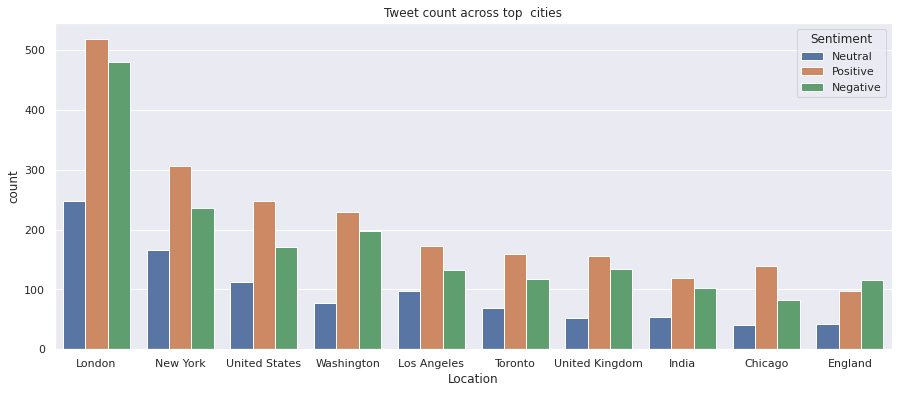

In [141]:
sns.set(rc={'figure.figsize':(15,6)})
gg = train.Location.value_counts()[:10].index
plt.title("Tweet count across top  cities")
sns.countplot(x = "Location", hue = "Sentiment", data = plot_df, order = gg)

This gives more clear explanation between the location and sentiments
England is the odd one out of the whole locations, it has its negative sentiment higher than positive and neutral

Performing a time/data analysis

In [142]:
#Converting the time column to date time for easy analysis
train["TweetAt"] = pd.to_datetime(train["TweetAt"])

In [143]:
print('Earliest date: ', train['TweetAt'].min())
print('Latest Date', train['TweetAt'].max())

Earliest date:  2020-01-04 00:00:00
Latest Date 2020-12-04 00:00:00


It show that tweet was collected for over 11 months range

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:title={'center':'Tweet count across days'}, xlabel='day', ylabel='count'>

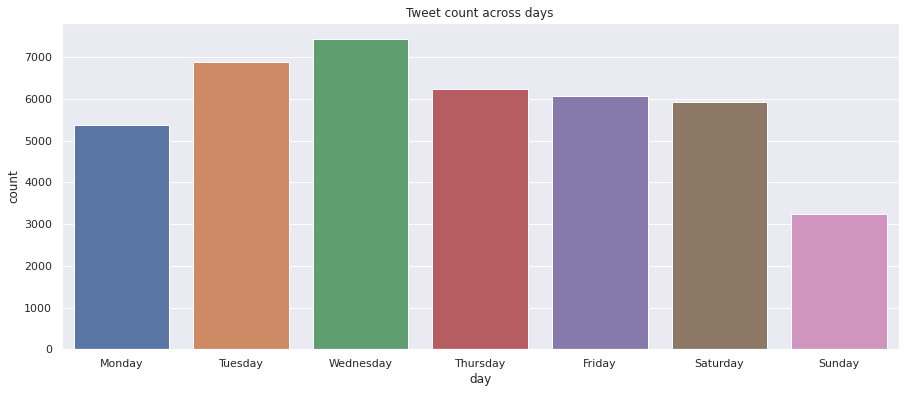

In [144]:
train["TweetAt"] = pd.to_datetime(train["TweetAt"])
train["day"] = train["TweetAt"].apply(lambda x : x.dayofweek)
key = {0: 'Monday', 1: 'Tuesday', 2:'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
train["day"] = train["day"].map(key)
plt.title("Tweet count across days")
sns.countplot(train["day"])

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:title={'center':'Tweet count across months'}, xlabel='month', ylabel='count'>

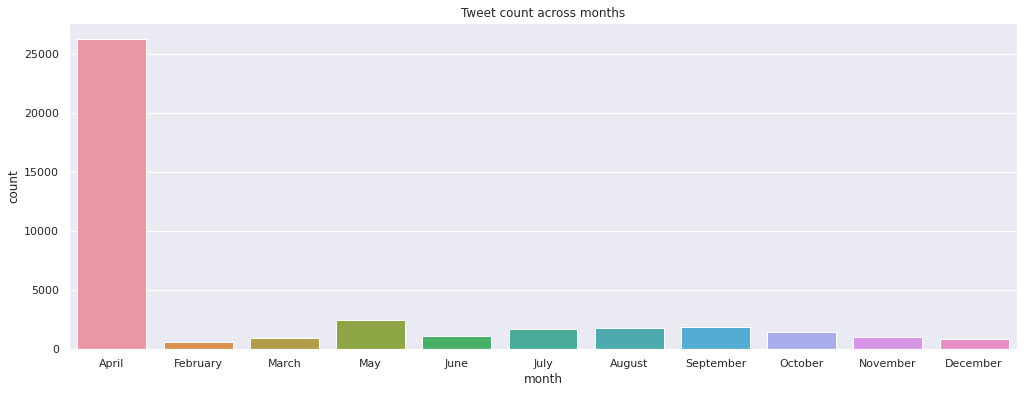

In [145]:
sns.set(rc={'figure.figsize':(17,6)})
train["TweetAt"] = pd.to_datetime(train["TweetAt"])
train["month"] = train["TweetAt"].apply(lambda x : x.month)
key = {0: 'January ', 1: 'February', 2:'March', 3: 'April', 4: 'May', 5: 'June', 6: 'July',
      7:'August', 8:'September', 9: 'October', 10: 'November', 11: 'December'  }
train["month"] = train["month"].map(key)
plt.title("Tweet count across months")
sns.countplot(train["month"])

Taking the tweet count across days and months only to find out that the tweets across months is skewed

In [146]:
train['month'].value_counts()

April        26309
May           2479
September     1881
August        1843
July          1742
October       1471
June          1131
November      1005
March          954
December       909
February       630
Name: month, dtype: int64

The numbers in April may be due to the highest cases in April

Corpus Analysis

In [147]:
for x in train.loc[:50, 'OriginalTweet']:
    print(x)
    print('\n')
    print('------------------------------\n')

@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8


------------------------------

advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate supplies of regular meds but not over order


------------------------------

Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P


------------------------------






#COVID19france #COVID_19 #COVID19 #coronavirus #confinement #Confinementotal #ConfinementGeneral https://t.co/zrlG0Z520j


------------------------------





#CoronavirusFrance #restezchezvous #StayAtHome #confinement https://t.co/usmuaLq72n


------------------------------

As news of the regionÂs first confirmed COVID-19 case came out of Sullivan County last week, people flocked to area stores to purchas

we can extract hashtags

In [148]:
hashtags=train['OriginalTweet'].str.extractall(r"(#\S+)")
freqs = hashtags[0].value_counts()
freqs[:20]

#coronavirus            12320
#COVID19                 3221
#Covid_19                2497
#Coronavirus             2081
#COVID2019               1603
#toiletpaper             1338
#covid19                 1100
#COVID?19                 792
#CoronaCrisis             719
#CoronaVirus              600
#SocialDistancing         598
#covid_19                 432
#CoronavirusPandemic      409
#CoronavirusOutbreak      391
#pandemic                 376
#StayHomeSaveLives        334
#Covid19                  331
#StayAtHome               319
#lockdown                 314
#supermarket              306
Name: 0, dtype: int64

Checking the Sentiments of the hashtag

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:title={'center':'Sentiment in tweets that trend #coronavirus'}, xlabel='Sentiment', ylabel='count'>

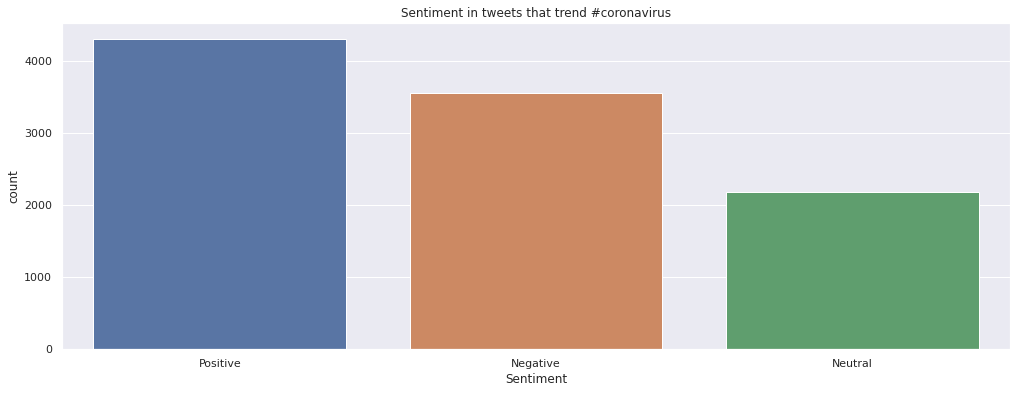

In [149]:
hashtag = train[train.OriginalTweet.str.contains(pat ='#coronavirus ')]
plt.title("Sentiment in tweets that trend #coronavirus")
sns.countplot(hashtag.Sentiment)

We can check mentions

In [150]:
mentions = train['OriginalTweet'].str.extractall(r"(@\S+)")
mentions = mentions[0].value_counts()
mentions[:20]

@realDonaldTrump    239
@Tesco              180
@sainsburys         152
@BorisJohnson       141
@narendramodi       110
@asda               103
@amazon              95
@PMOIndia            94
@Morrisons           87
@piersmorgan         84
@YouTube             83
@waitrose            70
@CNN                 56
@AldiUK              52
@FTC                 48
@Walmart             47
@CDCgov              44
@NYGovCuomo          42
@BBCNews             41
@SkyNews             40
Name: 0, dtype: int64

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:title={'center':'Sentiment in tweets that mention Trump'}, xlabel='Sentiment', ylabel='count'>

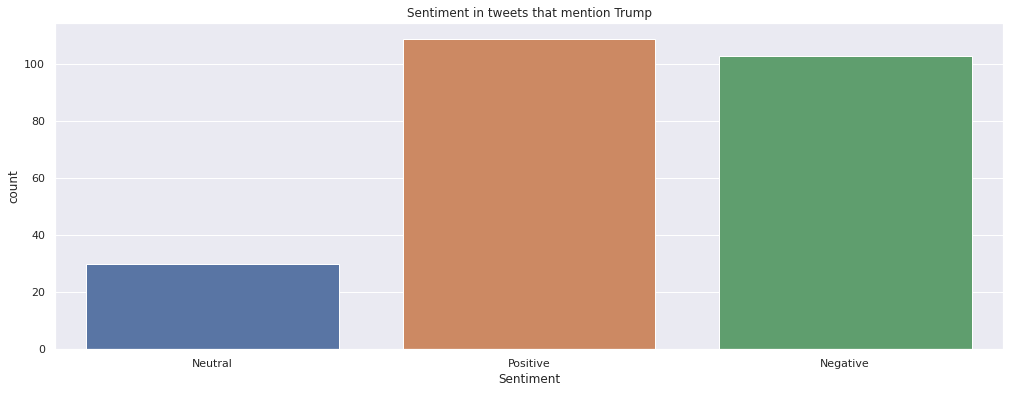

In [151]:
#regex function to find all rows that contain trump
result = train.OriginalTweet.str.contains(pat ='@realDonaldTrump')
trump=train[result]
plt.title("Sentiment in tweets that mention Trump")
sns.countplot(trump.Sentiment)

Cleaning the datasets
and to cleaan the datasets, we need to;
remove links and numbers
Remove Stopwords
Vectorize words

In [152]:
stop_word = stopwords.words('english')
def clean_data(df): 
    df.OriginalTweet = df.OriginalTweet.str.replace(r'(@\w*)','')

    #Removes URLs in the tweets
    df.OriginalTweet = df.OriginalTweet.str.replace(r"http\S+", "")

    #Remove hashtags
    df.OriginalTweet = df.OriginalTweet.str.replace(r'#\w+',"")

    #Removes uniques characters
    df.OriginalTweet = df.OriginalTweet.str.replace(r"[^a-zA-Z ]","")

    # Remove all extra spaces
    df.OriginalTweet = df.OriginalTweet.str.replace(r'( +)'," ")
    df.OriginalTweet = df.OriginalTweet.str.strip()

    # Changes characters to lowercase
    df.OriginalTweet = df.OriginalTweet.str.lower()
    
    return df

In [153]:
#applying cleaning function on train and test dataframes

temptr = train.iloc[:,[2,3]]
clean_train = clean_data(temptr)
tempte = test.iloc[:,[2,3]]
clean_test = clean_data(tempte)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:5489: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packa

In [154]:
def remove_stopwords(corpus):
    corpus = corpus.split()
    corpus = " ".join([word for word in corpus if not word in stop_word])
    return corpus

In [155]:
clean_train.head(10)

,OriginalTweet,Sentiment
0,and and,Neutral
1,advice talk to your neighbours family to excha...,Positive
2,coronavirus australia woolworths to give elder...,Positive
3,my food stock is not the only one which is emp...,Positive
4,me ready to go at supermarket during the outbr...,Negative
5,as news of the regions first confirmed covid c...,Positive
6,cashier at grocery store was sharing his insig...,Positive
7,was at the supermarket today didnt buy toilet ...,Neutral
8,due to covid our retail store and classroom in...,Positive
9,for corona preventionwe should stop to buy thi...,Negative


In [156]:
#Lambda function to remove stopwords
clean_train['OriginalTweet'] = clean_train['OriginalTweet'].apply(lambda x: remove_stopwords(x))
clean_test['OriginalTweet'] = clean_test['OriginalTweet'].apply(lambda x: remove_stopwords(x))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [157]:
#replacing empty strings with Nan
clean_train = clean_train.replace(r'^\s*$', np.NaN, regex=True)
clean_test = clean_test.replace(r'^\s*$', np.NaN, regex=True)

In [158]:
clean_train.OriginalTweet[16]

nan

In [159]:
#dropping nan
clean_train.dropna(inplace = True)
clean_test.dropna(inplace = True)

In [160]:
clean_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41106 entries, 1 to 41156
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   OriginalTweet  41106 non-null  object
 1   Sentiment      41106 non-null  object
dtypes: object(2)
memory usage: 963.4+ KB


In [161]:
#examination of tweets
for x in clean_train.loc[:50, 'OriginalTweet']:
    print(x)
    print('\n')
    print('------------------------\n')

advice talk neighbours family exchange phone numbers create contact list phone numbers neighbours schools employer chemist gp set online shopping accounts poss adequate supplies regular meds order


------------------------

coronavirus australia woolworths give elderly disabled dedicated shopping hours amid covid outbreak


------------------------

food stock one emptyplease dont panic enough food everyone take need stay calm stay safe


------------------------

ready go supermarket outbreaknot im paranoid food stock litteraly empty serious thing please dont panic causes shortage


------------------------

news regions first confirmed covid case came sullivan county last week people flocked area stores purchase cleaning supplies hand sanitizer food toilet paper goods reports


------------------------

cashier grocery store sharing insights prove credibility commented im civics class know im talking


------------------------

supermarket today didnt buy toilet paper


------------

In [162]:
Corpus = ' '.join([i for i in clean_train['OriginalTweet']]).split() 

In [163]:
Corpus[2]

'neighbours'

Unigrams, Bigrams and Trigrams
Ngrams show the relationships and probabilistic tendences that certain words appear together

In [164]:
unigram = pd.Series(nltk.ngrams(Corpus, 1)).value_counts()[:15]
unigram = pd.DataFrame(unigram)
unigram['sn'] = unigram.index
unigram

,0,sn
"(covid,)",10233,"(covid,)"
"(prices,)",7691,"(prices,)"
"(food,)",6687,"(food,)"
"(store,)",6686,"(store,)"
"(supermarket,)",6561,"(supermarket,)"
"(grocery,)",6021,"(grocery,)"
"(people,)",5401,"(people,)"
"(amp,)",4950,"(amp,)"
"(consumer,)",4230,"(consumer,)"
"(shopping,)",3323,"(shopping,)"


In [165]:
bigram = pd.Series(nltk.ngrams(Corpus, 2)).value_counts()[:15]
bigram = pd.DataFrame(bigram)
bigram

,0
"(grocery, store)",4591
"(hand, sanitizer)",1451
"(online, shopping)",1289
"(toilet, paper)",1192
"(panic, buying)",1041
"(covid, pandemic)",880
"(oil, prices)",867
"(social, distancing)",608
"(due, covid)",549
"(stay, home)",472


In [166]:
bigram = pd.Series(nltk.ngrams(Corpus, 2)).value_counts()[:15]
bigram = pd.DataFrame(bigram)
bigram

,0
"(grocery, store)",4591
"(hand, sanitizer)",1451
"(online, shopping)",1289
"(toilet, paper)",1192
"(panic, buying)",1041
"(covid, pandemic)",880
"(oil, prices)",867
"(social, distancing)",608
"(due, covid)",549
"(stay, home)",472


Data Preprocessing

In [167]:
tokenizer = Tokenizer()

In [168]:
def tokenize(df):
    nltk_tokens = nltk.word_tokenize(df)
    return nltk_tokens

clean_train['tokens'] =  clean_train['OriginalTweet'].apply(lambda x: tokenize(x))
clean_train.tokens = clean_train.apply(lambda x: " ".join(x.tokens),axis=1)


clean_test['tokens'] =  clean_test['OriginalTweet'].apply(lambda x: tokenize(x))
clean_test.tokens = clean_test.apply(lambda x: " ".join(x.tokens),axis=1)

In [169]:
clean_test.columns

Index(['OriginalTweet', 'Sentiment', 'tokens'], dtype='object')

In [170]:
clean_test

,OriginalTweet,Sentiment,tokens
0,trending new yorkers encounter empty supermark...,Negative,trending new yorkers encounter empty supermark...
1,couldnt find hand sanitizer fred meyer turned ...,Positive,couldnt find hand sanitizer fred meyer turned ...
2,find protect loved ones,Positive,find protect loved ones
3,buying hits city anxious shoppers stock foodam...,Negative,buying hits city anxious shoppers stock foodam...
4,one week everyone buying baby milk powder next...,Neutral,one week everyone buying baby milk powder next...
...,...,...,...
3793,meanwhile supermarket israel people dance sing...,Positive,meanwhile supermarket israel people dance sing...
3794,panic buy lot nonperishable items echo needs f...,Negative,panic buy lot nonperishable items echo needs f...
3795,asst prof economics talking recent research co...,Neutral,asst prof economics talking recent research co...
3796,gov need somethings instead biar je rakyat ass...,Negative,gov need somethings instead biar je rakyat ass...


Vectorization

In [171]:
from sklearn.preprocessing import OrdinalEncoder
ord_enc = OrdinalEncoder()
clean_train["y_nominal"] = ord_enc.fit_transform(clean_train[["Sentiment"]])
clean_test["y_nominal"] = ord_enc.fit_transform(clean_test[["Sentiment"]])

X_train, X_test, y_train, y_test = train_test_split(clean_train['tokens'],
                                                    clean_train['y_nominal'], test_size=0.2,random_state=42)

In [172]:
clean_train.shape

(41106, 4)

In [173]:
#initialize vectorizer
vector = CountVectorizer(stop_words='english',ngram_range=(1,2),min_df=5).fit(clean_train['tokens'])
#initially min_df = 5

# Transforms a collection of text documents into a matrix of token counts
x_train_vectorized = vector.transform(X_train)
x_test_vectorized = vector.transform(X_test)

In [174]:
ord_enc.categories_

[array(['Negative', 'Neutral', 'Positive'], dtype=object)]

Modeling


Logistic Regression
Usually a model selection techniques would occur here, but since the model to be used was explicitly stated; we jump straight into training and parameter tuning using Gridsearch.

In [176]:
LR = LogisticRegression()
# Create regularization penalty space
penalty = ['l2']

# Create regularization hyperparameter space
C = np.logspace(0, 4, 10)

# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)

In [177]:
# Create grid search using 5-fold cross validation
clf = GridSearchCV(LR, hyperparameters, cv=5, verbose=0)

In [178]:
x_train_vectorized.shape

(32884, 19327)

In [179]:
# Fit grid search to find the best model
best_model = clf.fit(x_train_vectorized, y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [180]:
# View best hyperparameters
print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best C:', best_model.best_estimator_.get_params()['C'])

Best Penalty: l2
Best C: 1.0


Results

In [181]:
#Classification Report
y_pred = best_model.predict(x_test_vectorized)

In [182]:
report = classification_report(y_test, y_pred)
print(report)

#confusion matrix
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.82      0.79      0.81      3077
         1.0       0.68      0.73      0.70      1530
         2.0       0.83      0.83      0.83      3615

    accuracy                           0.80      8222
   macro avg       0.78      0.78      0.78      8222
weighted avg       0.80      0.80      0.80      8222

[[2443  257  377]
 [ 198 1112  220]
 [ 345  273 2997]]


<AxesSubplot:>

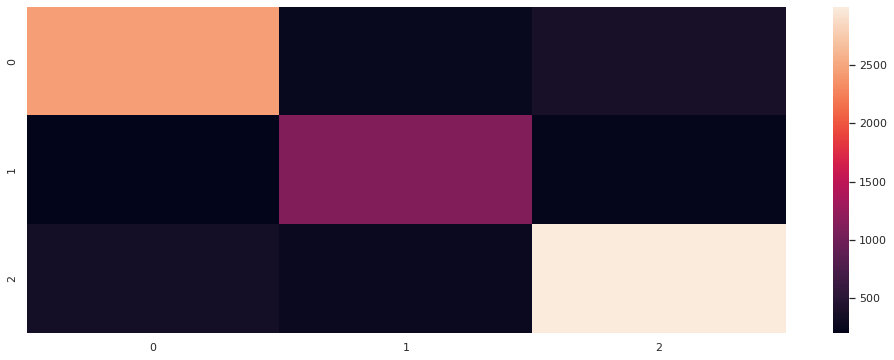

In [183]:
sns.heatmap(confusion_matrix(y_test, y_pred))

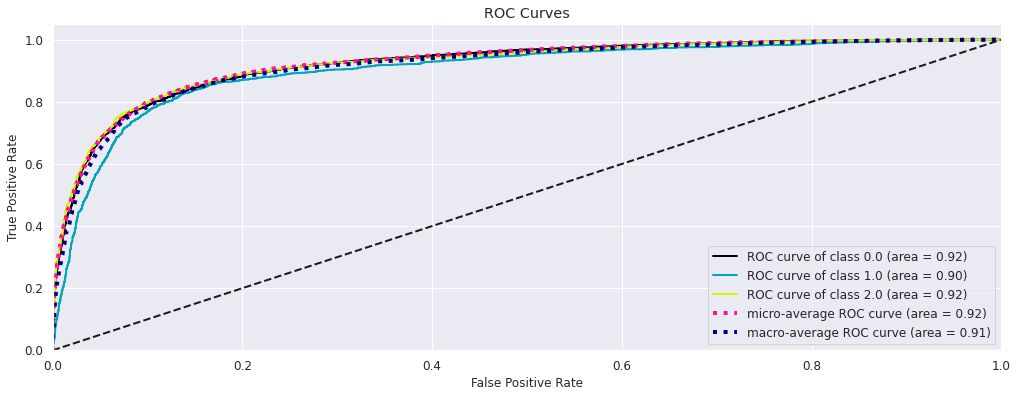

In [184]:
#ROC CURVE
import scikitplot as skplt
import matplotlib.pyplot as plt

y_probas = best_model.predict_proba(x_test_vectorized)
skplt.metrics.plot_roc(y_test, y_probas)
plt.show()

Results Discussion
The metric of choice for evaluation is

F1 Score

it is the harmonic mean between precision and recall and gives us a better measure. The positive class was the most accurately predicted, then Negative and Neutral across all metrics Precision, Recall and F1.

The results are consistent with the amount of tweets available per class. Positive class highest accuracy, followed by Negative and Neutral. It is a simply a matter or more data. To get better scores on the neutral class or overall, the following options can be considerered

Collect more data: more
Sampling: This can be done in a number of ways.The majority classes (in this case Positive and Negative) can be undersampled. Equally, the minority class can be Oversampled to match the majority. The weights of the different classes can also be modified for uniformity. Weighing the input of the minority class higher than the majority classes or vice versa.
Utilize other word vectorizers: Vectorizers like TFid, Word2Vec or frameworks like Gensim can be utilized.
More Parameter tuning: The model can be finetuned further to slightly improve scores

LSTM


A seperate tokenizer was used to fit the LSTM. The sequences were padded with zeros for uniformity across the dataset

In [185]:
tokenizerlstm = Tokenizer( split=' ')
tokenizerlstm.fit_on_texts(clean_train['OriginalTweet'].values)

X = tokenizerlstm.texts_to_sequences(clean_train['OriginalTweet'])

X = pad_sequences(X)

In [186]:
vocabSize = len(tokenizerlstm.word_index) + 1
vocabSize

41940

The LSTM model was created with a sequential Keras object. It contains an Embedded layer, LSTM and sense layer for output.

In [187]:
embed_dim = 128
lstm_out = 196
model = Sequential()
model.add(Embedding(vocabSize, embed_dim,input_length = 28))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3,activation='softmax'))
model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])

The target variable was binarized to correspond with the logit pairs for the LSTM model.

In [188]:
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing

Le = LabelEncoder()
lb = preprocessing.LabelBinarizer()

y_train = lb.fit_transform(clean_train['Sentiment'])

In [189]:
y_test = lb.fit_transform(clean_test['Sentiment'])

In [190]:
y_train.shape

(41106, 3)

Model Training

In [ ]:
X_trainl, X_testl, y_trainl, y_testl = train_test_split(X,y_train, test_size = 0.15, random_state = 42)

model.fit(X_trainl, y_trainl,validation_data = (X_testl,y_testl),epochs = 10, batch_size=32)


Epoch 1/10
 733/1092 [===================>..........] - ETA: 1:04 - loss: 0.5088 - accuracy: 0.5876

In [ ]:
#tokenizerlstm = Tokenizer( split=' ')
#tokenizerlstm.fit_on_texts(clean_train['OriginalTweet'].values)

test_lstm = tokenizerlstm.texts_to_sequences(clean_test['OriginalTweet'])

test_lstm = pad_sequences(test_lstm)

In [ ]:
lstm_pred = model.predict_classes(test_lstm)

In [ ]:
print(classification_report(np.argmax(y_test,1), lstm_pred))

In [ ]:
print(confusion_matrix(np.argmax(y_test,1), lstm_pred))

Results Discussion
Interstingly the Logistic Regression Classifier performed almost the same as the LSTM Model. The results are near identical except the macro average recall where the LSTM model edged out the LR model by 0.01. However the LSTM model used was not state of the art, presumably the results would have been better.

Similar recommendations given to LR model can be applied to the LSTM model, such as gathering more data, sampling and other word vectorizers.

Most importantly, the model structure. No single LSTM is the best for text processing as finding the best model is a leading topic in the literature. Hence other model structures can be experimented with in the future.

 